# USAID Forecasting Challenge 


## Objective
Develop a project framework that can be used for forecasting contraceptive product consumption in Cote d'Ivoire. During this process we hope to foster an exchange of technology and ideas to foster shared development between Cote d'Ivoire and Haiti.

### Target the next three months of stock distributed for each product?
The target variable in the original dataset is `stock_distributed` this variable represents the number of a product distributed.
 


## Data Processing and Transformations
The data for this notebook is available in the analytical_data folder which will be populated with the sequential execution of the analytical notebooks.

## Model Development Overview
General overview of model development and evaluation steps:
    1. Load Data
        a. Combine the datasets into one final dataset for modeling
    2. Set the data model parameters
        - Select features
        - Index cols
        - Target col
        - Timeseries keys
    3. Select the model to develop and test
    4. Evaluate the model
        - evaluation metrics
        

## Data
Please refer to other notebooks for exploration of the data and processing.

### Analytical Transformations

#### 1. New Features on the original logistics data
    - adding a stock_out binary variable
    - adding lagging descriptive statistics for each variable for 3,6, 12 months

#### 2. Creation of a product clustering model
    - Create a clustering based on aggregated product data usage across all the sites from 2016-2018

#### 3. Creation of a district clustering model
    - Create a clustering based on aggregated district data usage across all the sites from 2016-2018

### Additional Transformations (Future)

### Additional Data not used
- population data
- Site specific data
- satelite data

## Model Development
- Looking for a regression model to preduct a continous variable 
- Develop a solid evaluation model template that we can evaluate step-wise, in 3-month evaluations of th

### Model Selection
- OLS
- Random Forest
- Ensemble Methods
- Neural Net

### Model Evaluation
- Need a model that predicts well on the most common product with the busiest sites
    - create a visualization that shows how well the model does across condoms in all sites vs New or Underutilized Contraceptives
    



## Recreating the submission template
Recreate the problem. 
Only have 4 factors to make a submission: month, year, site_code, and product_code. With holding all other data make a prediction of the future.

Here we create indexes to help us in separating records to create the training and splitting in the dataset.


#### Creating the processed training data
Inside here we label the index_columns. 
    1. We use the sortkeys to determine how to sort the data.
    2. We extract a separate mapping from the index to create the timeseries mappings to produce windows.
    3. We create a dataframe groupings like we did for the index
    4. WE map the time index to the samples and create testing and training indexes

### Load and evaluate the models on the Original Dataset

In [1]:
# File Managment
import os
import re

# Scientific Computing
import pandas as pd
import numpy as np

# Data Visualization and analysis

import matplotlib.pyplot as plt

In [2]:
# Load in the data provided by USAID for download
original_data = pd.read_csv("final_data/contraceptive_logistics_data.csv") 

### The First Model has a single independent variable: `stock_ordered`

We know from the dataset the index columns are year,month,site_code and product_code.

We also know we want to know we want to sort the columns by month and year.

#### Create model dataset

In [3]:
# Model Data Parameters
# The initial values to index the data by
index_cols = ['year','month','site_code','product_code']

# Update the training set based on the window size and selection of features
select_cols = ['stock_ordered'] # also called `original_cols`

# time series
timeseries_keys = ['month','year']# This should be ['year','month'] for optimal results

# Target columns
target_col = 'stock_distributed'

### Model Training Datasets

#### X & Y
Split the data between input features and target varible

### Training, Testing and Validating



In [4]:
# File Managment
import os
import re

# Scientific Computing
import pandas as pd
import numpy as np

# Data Visualization and analysis

import matplotlib.pyplot as plt

# Data Processing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder


def create_index(index_array,sort_keys,ascending = True):
    # Isolate sort key values
    array_steps = index_array[sort_keys].drop_duplicates()
    # Sort keys
    array_steps = array_steps.sort_values(by=sort_keys,ascending = ascending)
    # Create index match
    array_steps = array_steps.reset_index(drop=True).reset_index()
    return array_steps

# This is a cheap function replace columns, something more clever should be easy to develop
# Perhaps:
# x[cols] = y[cols]
def replace_values(x,y,cols):
    for col in cols:
        x[col] = y[col]
    return x


def create_validation_set(X_train,X_validate,X_test,index,index_features,select_features,window_size = 3):
    index_split =  len(np.unique(index['ts_index'])) - window_size
    index_split_down = index['ts_index'] <= index_split
    index_split_up = index['ts_index'] > index_split
    window_records =  (index['ts_index'] <= index_split) & (index['ts_index'] > index_split-window_size)
    
    train_valid = X_train[window_records]
    train_valid =train_valid.merge(index[['site_code','product_code']],left_index=True,right_index=True)
    
    # Impute the validation data by taking the last 3 values for the index featrues
    # Should change index features from site_code,product_code in the future
    calc_site_product_avg = train_valid.groupby(['site_code','product_code'])[select_features].mean()
    calc_site_product_avg = calc_site_product_avg.reset_index()
    #map index labels of the values created with site_code and product to the index
    # use the index split_up
    # Map the new results to replace X_validate
    #
    new_validation_data = index[index_split_up].merge(calc_site_product_avg,on =['site_code','product_code'],how='left')
    #new_validation_index.head()

    len(new_validation_data)
    
    # Fill in the missing values
    new_validation_data = new_validation_data.fillna(0).set_index('index')
    
    
    # Replace the numeric values with the ones calculated
    X_validate = replace_values(X_validate,new_validation_data,select_features)

    
    # Replace the labels with the appropriate values from the index
    X_validate = replace_values(X_validate,X_test,index_features)
    
    return X_validate

def process_datasets(df,target_col,index_cols,ts_keys=None):
    """
    Process the data by encoding categorical variables and imputing missing values
    
    """
    try:
        assert type(index_cols) == list
    except:
        print('`index_cols` needs to be a list type')
        raise
    dev_data = df
    
    
    le = LabelEncoder()
    # Create an index that I can select records for based on the month_year
    
    # Which features need to be label for the model
    col_labels = []
    for col in index_cols:
        col_label = col+'_label'
        dev_data[col_label] =  dev_data[col].astype('str')
        dev_data[col_label] = le.fit_transform(dev_data[col_label])
        col_labels.append(col_label)

    # Separate the dependent and independent variables
    
    # Create an index to maintain identity of individual records
    # Merge data with the Index created and assign a new index
    # Basic index wait, replace with one for each record
    index = create_index(df,index_cols)
    dev_data = index.merge(dev_data,on=index_cols)
    
    # Assign the new index after the merge
    dev_data = dev_data.set_index('index')
    #print(dev_data[['year','month']].drop_duplicates())
    
    # Remove the coded columns and target column
    X = dev_data.drop(columns =  index_cols + [target_col] ).copy()
    
    # Keep these other values for sorting and indexing later
    y = dev_data.loc[:, target_col].copy()
    
    # Replace Inf values NA
    X = X.replace([np.inf, -np.inf], np.nan)
    
    # Select Target variables
    X = X.fillna(0)
    
    # Create a time series index
    ts_index = create_index(index,ts_keys).rename(columns={'index':'ts_index'})
    # match ts index with normal index, then select based on index
    index = index.merge(ts_index,on = ts_keys)
    
    
    return X, y, index, col_labels




def create_model_datasets(X,y,index,x_features,col_labels,windows):
    """
    Create a series of datasets to do train,test and validate with.
    
    """
    #X = 
    # Create split train,test and validate
    
    # Split the dataset by date to get the most recent windows for evaluation
    ts_index = index['ts_index']
    index_split =  len(np.unique(ts_index)) - windows
    index_split_down = ts_index <= index_split
    index_split_up = ts_index > index_split
    
    # Print the index point at which the data will be split
    print(index_split)
    # Split the data set in to training and test sets
    # Create Dependent
    X_train = X[index_split_down].loc[:,x_features]
    X_test = X[index_split_up].loc[:,x_features]
    # Create Target
    y_train = y[index_split_down]
    y_test = y[index_split_up]
    
    if not len(X) == len(X_train) + len(X_test):
        print("Lengths do not match up!!!")
        raise
    # Print out the shape of each dataset
    #for i in [X_train,X_test,y_train,y_test]:
    #    print("Shape of:")
    #    print(i.shape)
    # Impute missing values in the dataset by incorporating information from the other features
    imputer = IterativeImputer(max_iter=10, random_state=42)
    imputer.fit(X_train)
    
    # Impute the missing data
    # Set the index of the training dataset so it matches the original index provided
    X_train = pd.DataFrame(np.round(imputer.transform(X_train)),columns =X_train.columns).set_index(X_train.index.values)
    
    X_test = pd.DataFrame(np.round(imputer.transform(X_test)),columns =X_test.columns).set_index(X_test.index.values)
    
    
    # Create a test dataset by imputing values from a matrix of zeroes
    
    X_validate = np.zeros(X_test.shape)
    
    # We will use this dataset to imagine if we had no information to make a prediction
    X_validate = pd.DataFrame(X_validate,columns =X_test.columns).set_index(X_test.index.values)
    
    # Create a validation dataset using the most recent three months of data
    X_validate = create_validation_set(X_train,X_validate,X_test,index,col_labels,x_features,window_size = windows)
    
    return X_train, X_test, X_validate, y_train, y_test



def create_datasets(data,target_col,select_cols,index_cols,ts_keys, window = 3):
    # Create the x,y and index objects
    X, y, index,col_labels =  process_datasets(data,target_col,index_cols,ts_keys=ts_keys)
    
    # This is a mistake
    #select_cols = [ col for col in data.columns.values if col not in col_labels +[target_col]]
    #select_cols = [ col for col in analytical_data.columns.values if col not in index_cols +[target_col]]
    
    # Create Dataset splits for train-test-validate
    X_train, X_test, X_validate, y_train, y_test = create_model_datasets(
        X = X,
        y = y,
        index = index,
        x_features = select_cols+col_labels ,
        col_labels=col_labels,
        windows = window) # We could make the window size adjustable, also adjust the imputed data
    
    return X_train, X_test, X_validate, y_train, y_test

In [5]:
# Create the model training data

X_train, X_test, X_validate, y_train, y_test = create_datasets(original_data,target_col,select_cols,index_cols,timeseries_keys)

42


<ipython-input-4-138f77a55f63>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_valid = X_train[window_records]


# Model Development


## Model Evaluation
The challenge requests that we use Mean-Absolute Scaled Error to evaluate model performance.

### Evaluate different regression models

- Root Mean-Square Error (RMSE)
- Mean-Absolue Scaled Error (MASE)

We can look to the Zindi leaderboard for help in terms of evaluating our model progression and development however the leaderboard looks to minimize RMSE. Public results on September 8th, 2020
    * Place #5 on Zindi Leaderboard is 34.48
    * Place #3 on Zindi Leaderboard is 19.881 
    * Place #1 on Zindi Leaderboard is 10.284

In [6]:


# Model Selection
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import yellowbrick as yb 
from yellowbrick.regressor import prediction_error, residuals_plot
from yellowbrick.regressor.alphas import AlphaSelection
from yellowbrick.contrib.statsmodels.base import *
from yellowbrick.model_selection import FeatureImportances


# Model Evaluation
from sklearn import metrics


# Regressor models
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# I'm leaving this here as a reminder for further analysis later.
# Test for stationarity in the time-series data
from statsmodels.tsa.stattools import adfuller




def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
# Try OLS Model
sm_OLS = StatsModelsWrapper(sm.OLS)

ols_model = sm_OLS
ols_model.fit(X_train,y_train)

def predict_model(model,X_test,y_test):
    """
    A function to evaluate a fitted model and produce evaluation metrics and predicted values.
    # Try OLS Model
    from statsmodels.api.core import StatsModelsWrapper
    sm_OLS = StatsModelsWrapper(sm.OLS)

    ols_model = sm_OLS
    ols_model.fit(X_train,y_train)
    predict_model(ols_model,X_test,y_test)
    """
    # Calculate the predicted values
    y_pred = model.predict(X_test)
    

    # Test the model on witheld test data
    # accuracy and error calcs
    
    r2 = metrics.r2_score(y_test, y_pred)
    mase = MASE(y_train,y_test,y_pred)
    rmse= np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    # Package them in a tuple
    eval_metrics = (r2,mase,rmse)
    return eval_metrics, y_pred

eval_metrics, y_pred = predict_model(ols_model,X_test,y_test)
val_metrics, ry_pred =predict_model(ols_model,X_validate,y_test)
print(eval_metrics)
print(val_metrics)

(-0.531416042776107, 0.7081107887881235, 47.18816723692946)
(0.08371078966049317, 0.6900054253080647, 36.50083503871133)


### Create a model with only the index values labeled

#### Simple Model, Poor Results

The OLS regression produced an RMSE score of 47.18 in the test data and 36.5 from the validated data. We generally expect the results of the test data to indicate better performance than the validated data. For this reason we will refer to the model performance with this data for model evaluation.

- The model performance is pretty bad across the board but we also know that an RMSE of 36.5 is just higher the  cutoff for the top 5 models on the Zindi Leaderboard.

## Evaluating multiple models

In [8]:
def regressor_eval_vizs(model,X_train,X_test,y_train,y_test):
    # Residuals
    viz_res_plot = residuals_plot(model, X_train, y_train, X_test, y_test)
    # Prediction
    viz_prd_error = prediction_error(model, X_train, y_train, X_test, y_test)
    # FEature Importance
    viz_FeatureImportances = FeatureImportances(model)
    viz_FeatureImportances.fit(X_train, y_train)
    viz_FeatureImportances.show()
    


def evaluate_dataset(X_train,X_test,X_validate,y_train,y_test,test_models,show_models=False):

    # Iterate Over and evaluate the models to predict the entire dataset
    model_results = pd.DataFrame()

    for key in test_models.keys():
        # Create the new model
        #print("\n"+"_"*20)
        #print(key)
        model = test_models[key]
        model.fit(X_train,y_train)
        try:
            # Evaluate Model
            eval_metrics, y_pred = predict_model(model,X_test,y_test)
            #print(eval_metrics)

            # The score based on our current model with no knowledge of the future results
            val_metrics, vy_pred = predict_model(model,X_validate,y_test)
            #print(val_metrics)
            
            # Test the model on witheld test data
            # accuracy and error calcs
            r2,mase,rmse = eval_metrics
            

            # Test the model on imputed test data (validate)
            # accuracy and error calcs
            r2v,masev,rmsev = val_metrics
            
            # Create model results
            model_results = model_results.append(pd.DataFrame(
                data = [(key,r2,rmse,mase,r2v,rmsev,masev)],
                columns = ['model','r2','rmse','mase','r2-validated','rmse-validated','mase-validated']))

            # Create Several Plot figures to evaluate the model results
            if show_models:
                try:
                    regressor_eval_vizs(test_models[key], X_train, X_validate,y_train, y_test)
                except:
                    print(f"Viz not yet implemented in Yellowbrinck for this model: {key}")
        except:
            print("The models could not be evaluated")
            print("Shape of y_pred: ",y_pred.shape)
            print("Shape of y_pred-validated: ",y_pred_v.shape)

    print(model_results[model_results['mase-validated']==model_results['mase-validated'].min()])
    return model_results

In [9]:
test_models = {
    'Pooled':sm_OLS,
    'XGBoost' : XGBRegressor(n_estimators=100),
    'Ridge':Ridge(),
    'Lasso':Lasso(),
    'RandomForest':RandomForestRegressor(),
    'BaggingRegressor':BaggingRegressor(),
    'MLPRegressor':MLPRegressor(),
    'BayesianRidge':BayesianRidge(),
}


model_results = evaluate_dataset(X_train,
                                  X_test,
                                  X_validate,
                                  y_train,
                                  y_test,
                                  test_models,
                                  show_models=False)
model_results

          model        r2      rmse      mase  r2-validated  rmse-validated  \
0  RandomForest  0.318055  31.48916  0.522398       0.30961       31.683543   

   mase-validated  
0        0.560941  


,model,r2,rmse,mase,r2-validated,rmse-validated,mase-validated
0,Pooled,-0.531416,47.188167,0.708111,0.083711,36.500835,0.690005
0,XGBoost,0.362191,30.453123,0.547757,0.315457,31.549102,0.582602
0,Ridge,-0.438324,45.731437,0.776315,0.105119,36.071903,0.761672
0,Lasso,-0.437457,45.717656,0.777990,0.104991,36.074491,0.763655
0,RandomForest,0.318055,31.489160,0.522398,0.309610,31.683543,0.560941
0,BaggingRegressor,0.308037,31.719609,0.540883,0.271336,32.549940,0.573725
0,MLPRegressor,0.118085,35.809637,0.703109,0.194849,34.215688,0.689870
0,BayesianRidge,-0.438364,45.732068,0.776369,0.105118,36.071924,0.761750


### Early Results
Lets evaluate the models based on the validation data but aspire to get the model to meet the test model through improved modeling of the input data. 
- We can see the best model produces a MASE of 0.561 and the and RMSE off 31.68, this would put us within the top 5 of the Zindi leaderboard just by trying some more advanced models.


## Next try creating a model with no input values

In [10]:
# Load the data
# Load in the data provided by USAID for download
original_data = pd.read_csv("final_data/contraceptive_logistics_data.csv") 


# The initial values to index the data by
index_cols = ['year','month','site_code','product_code']

# Update the training set based on the window size and selection of features
select_cols = [] # Try using no columns

# Target cols
target_col = 'stock_distributed'

X_train, X_test, X_validate, y_train, y_test = create_datasets(original_data,target_col,select_cols,index_cols,timeseries_keys)

# Select the models to test
test_models = {
    'Pooled':sm_OLS,
    'XGBoost' : XGBRegressor(n_estimators=100),
    'RandomForest':RandomForestRegressor()
}

# Evaluate a series of models 
model_results = evaluate_dataset(X_train,
                                              X_test,
                                              X_validate,
                                              y_train,
                                              y_test,
                                              test_models,
                                              show_models=False)

model_results

42


<ipython-input-4-138f77a55f63>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_valid = X_train[window_records]


          model        r2      rmse      mase  r2-validated  rmse-validated  \
0  RandomForest  0.347065  30.81211  0.502039      0.347065        30.81211   

   mase-validated  
0        0.502039  


,model,r2,rmse,mase,r2-validated,rmse-validated,mase-validated
0,Pooled,-0.022768,38.563369,0.735611,-0.022768,38.563369,0.735611
0,XGBoost,0.346766,30.819159,0.569256,0.346766,30.819159,0.569256
0,RandomForest,0.347065,30.812110,0.502039,0.347065,30.812110,0.502039


#### Try creating a model with all the columns availabe in the original dataset

In [11]:
# Load the data
# Load in the data provided by USAID for download
original_data = pd.read_csv("final_data/contraceptive_logistics_data.csv") 

# Set the data parameters

# The initial values to index the data by
index_cols = ['year','month','site_code','product_code']

# Select numerical input parameters
select_cols = ['stock_initial',
 'stock_received',
 'stock_adjustment',
 'stock_end',
 'average_monthly_consumption',
 'stock_stockout_days',
 'stock_ordered']
# Once the dataset is too large, we could also use this to remove the catergorical variables
#select_cols = [ col for col in analytical_data.columns.values if col not in index_cols +[target_col]]



# Target cols
target_col = 'stock_distributed'

# Time Series
timeseries_keys = ['year','month']

# Create the model training sets
X_train, X_test, X_validate, y_train, y_test = create_datasets(original_data,target_col,select_cols,index_cols,timeseries_keys)


# Select the models to test
test_models = {
    'Pooled':sm_OLS,
    'XGBoost' : XGBRegressor(n_estimators=100),
    'RandomForest':RandomForestRegressor(),
}

# Evaluate a series of models 
model_results = evaluate_dataset(X_train,
                                  X_test,
                                  X_validate,
                                  y_train,
                                  y_test,
                                  test_models,
                                  show_models=False)
model_results

42


<ipython-input-4-138f77a55f63>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_valid = X_train[window_records]


     model        r2       rmse      mase  r2-validated  rmse-validated  \
0  XGBoost  0.798425  16.484555  0.145152      0.414458       28.095599   

   mase-validated  
0        0.433008  


,model,r2,rmse,mase,r2-validated,rmse-validated,mase-validated
0,Pooled,1.000000,1.170191e-13,2.101906e-15,0.231817,32.180400,0.448892
0,XGBoost,0.798425,1.648455e+01,1.451520e-01,0.414458,28.095599,0.433008
0,RandomForest,0.422142,2.791063e+01,1.941367e-01,0.290959,30.916816,0.447632


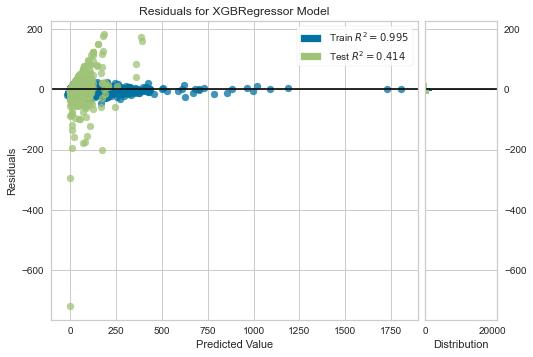

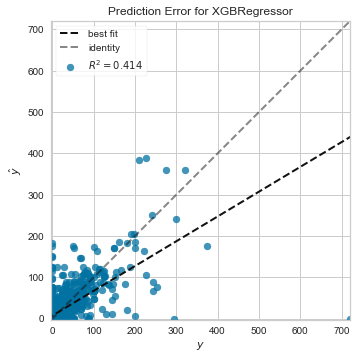

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


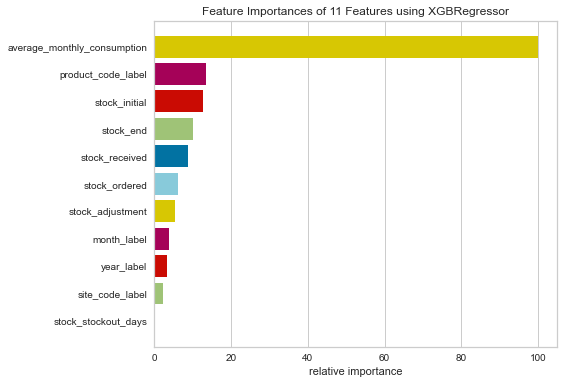

In [12]:
regressor_eval_vizs(test_models['XGBoost'], X_train, X_validate,y_train, y_test)

### Select features of most importance for the model only

In [13]:
# Load the data
# Load in the data provided by USAID for download
original_data = pd.read_csv("final_data/contraceptive_logistics_data.csv") 

# Set the data parameters

# The initial values to index the data by
index_cols = ['year','month','site_code','product_code']

# Select numerical input parameters

select_cols = ['stock_initial',
 'average_monthly_consumption',
 'stock_received',
 'stock_end']

# Create the model training sets
X_train, X_test, X_validate, y_train, y_test = create_datasets(original_data,target_col,select_cols,index_cols,timeseries_keys)


# Select the models to test
test_models = {
    'Pooled':sm_OLS,
    'XGBoost' : XGBRegressor(n_estimators=100),
    'RandomForest':RandomForestRegressor(),
}

# 

# Evaluate a series of models
model_results = evaluate_dataset(X_train,
                                  X_test,
                                  X_validate,
                                  y_train,
                                  y_test,
                                  test_models,
                                  show_models=False)


42


<ipython-input-4-138f77a55f63>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_valid = X_train[window_records]


     model        r2       rmse      mase  r2-validated  rmse-validated  \
0  XGBoost  0.755242  18.164666  0.181294      0.423864       27.869012   

   mase-validated  
0        0.435118  


#####  No big change in model performance
    - Continue to explore dataset transformations before doing feature pruning

## Analytical Lag Transformations Data

42


<ipython-input-4-138f77a55f63>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_valid = X_train[window_records]


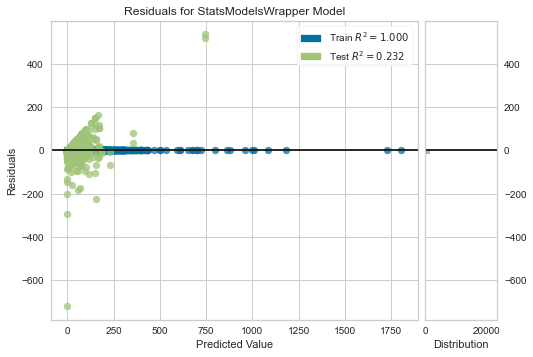

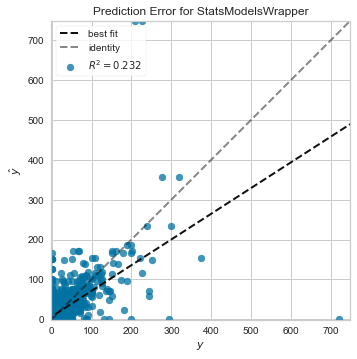

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Viz not yet implemented in Yellowbrinck for this model: Pooled


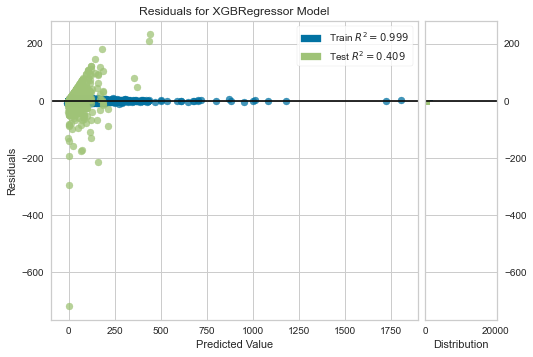

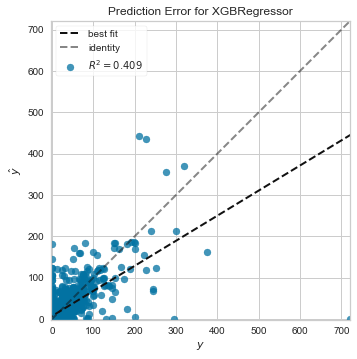

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


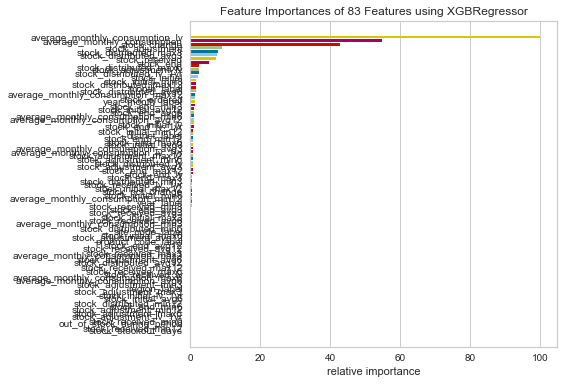

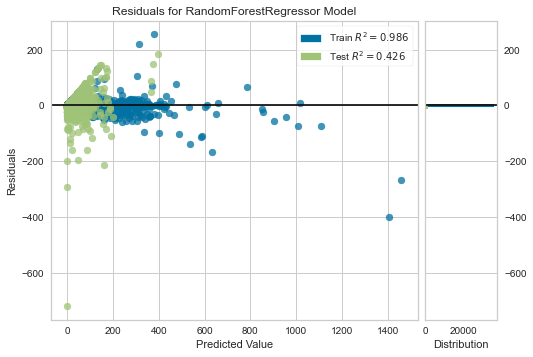

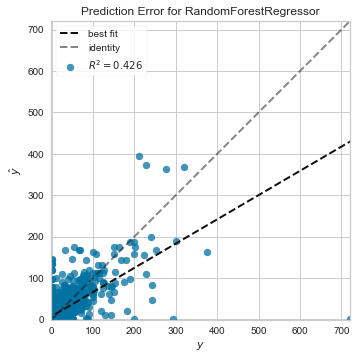

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


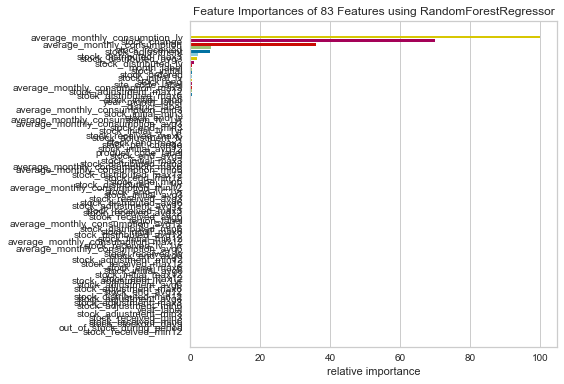

          model        r2       rmse      mase  r2-validated  rmse-validated  \
0  RandomForest  0.851359  14.155596  0.148612       0.42631       27.809806   

   mase-validated  
0        0.433143  


,model,r2,rmse,mase,r2-validated,rmse-validated,mase-validated
0,Pooled,1.000000,3.676182e-13,7.787144e-15,0.231817,32.180400,0.450352
0,XGBoost,0.944257,8.668717e+00,9.264214e-02,0.409470,28.214999,0.433457
0,RandomForest,0.851359,1.415560e+01,1.486124e-01,0.426310,27.809806,0.433143


In [14]:
# Load the data
analytical_data = pd.read_csv("analytical_data/analytical_logistics_data.csv")

# Set the data parameters
target_col = 'stock_distributed'
index_cols = ['year','month','region','district','site_code','product_code','year_month']
select_cols = [ col for col in analytical_data.columns.values if col not in index_cols +[target_col]]
timeseries_keys = ['year','month']

# Create the model training sets
X_train, X_test, X_validate, y_train, y_test = create_datasets(
    analytical_data,
    target_col,
    select_cols,
    index_cols,
    timeseries_keys)  # timeseries_keys <- this should be ('year','month'), we see improved results as such


# Select the models to test
test_models = {
    'Pooled':sm_OLS,
    'XGBoost' : XGBRegressor(n_estimators=100),
    'RandomForest':RandomForestRegressor(),
}

# 
# Evaluate a series of models
model_results = evaluate_dataset(X_train,
                                  X_test, # Validate the data
                                  X_validate,
                                  y_train,
                                  y_test,
                                  test_models,
                                  show_models=True)

model_results

### Final Analytical Dataset

156
156
42


<ipython-input-4-138f77a55f63>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_valid = X_train[window_records]


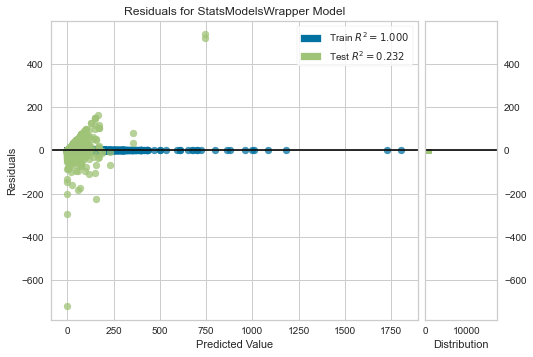

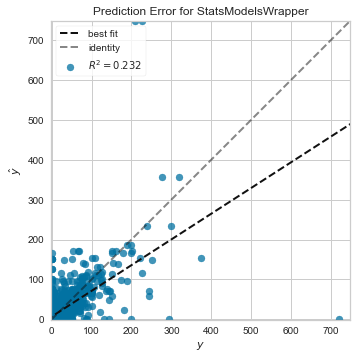

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Viz not yet implemented in Yellowbrinck for this model: Pooled


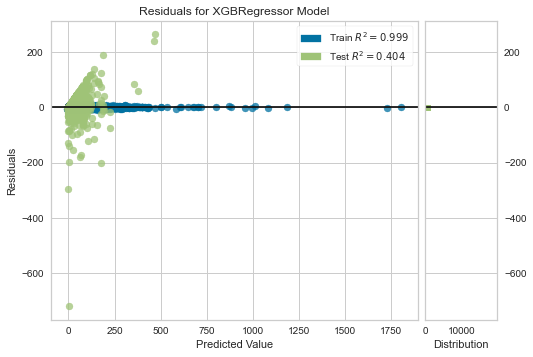

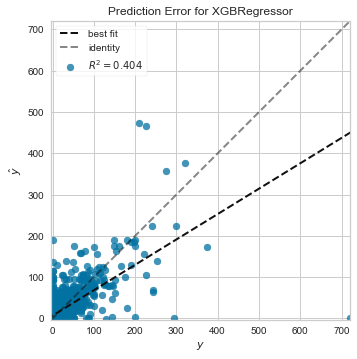

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


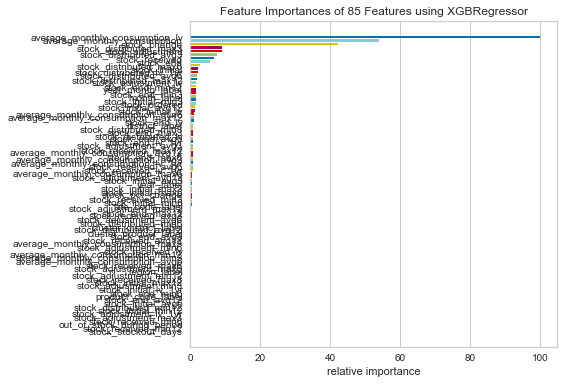

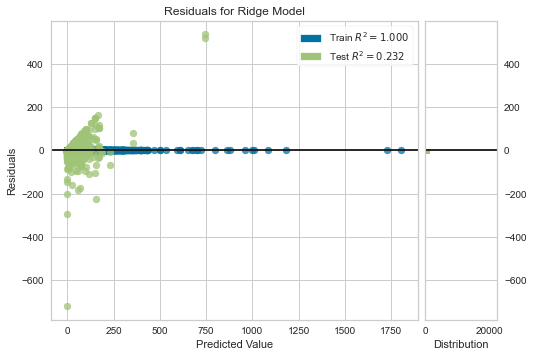

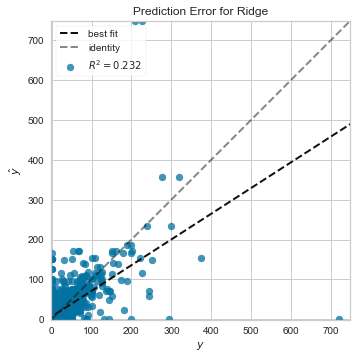

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


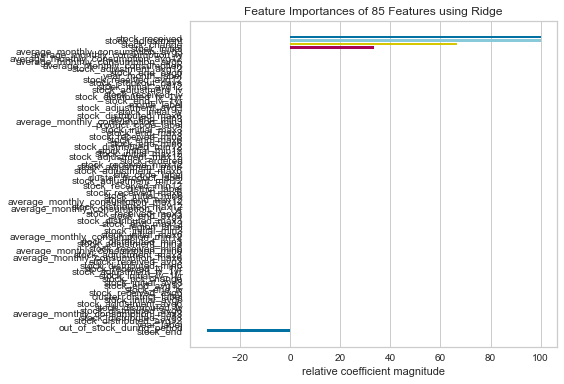

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7913.9711575947695, tolerance: 6129.208631194957
  model = cd_fast.enet_coordinate_descent(


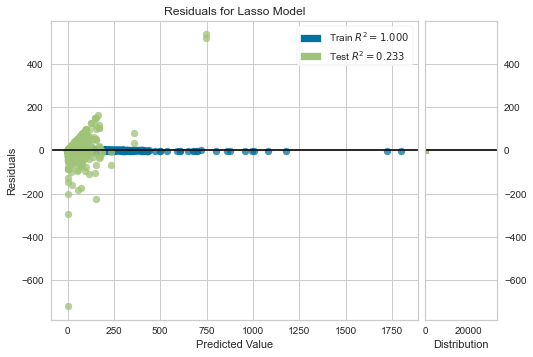

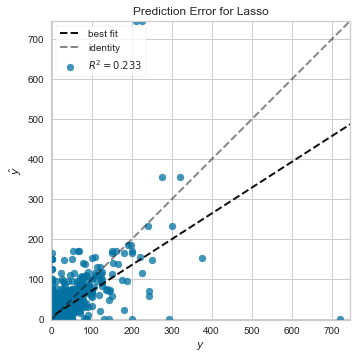

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


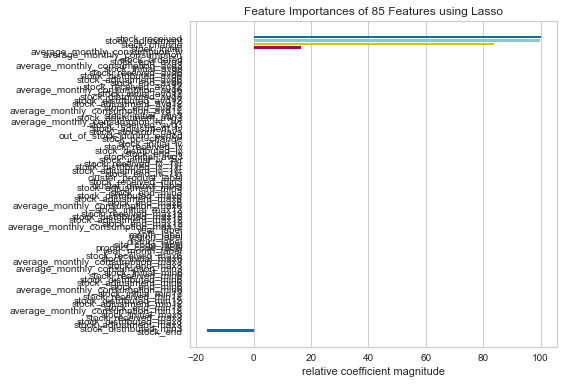

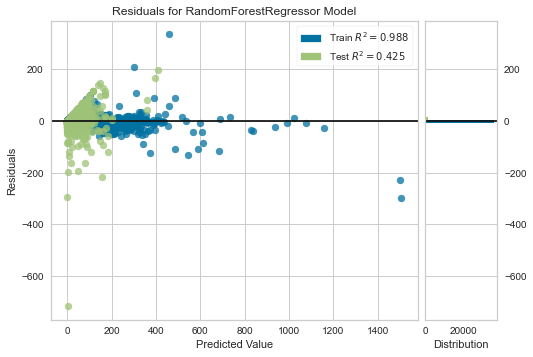

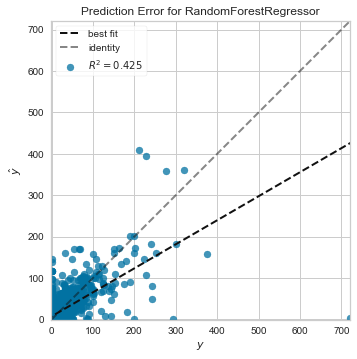

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


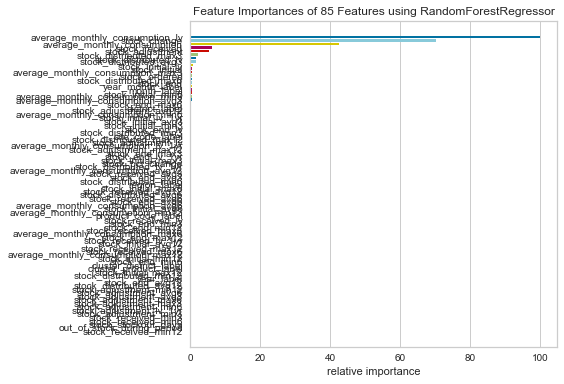

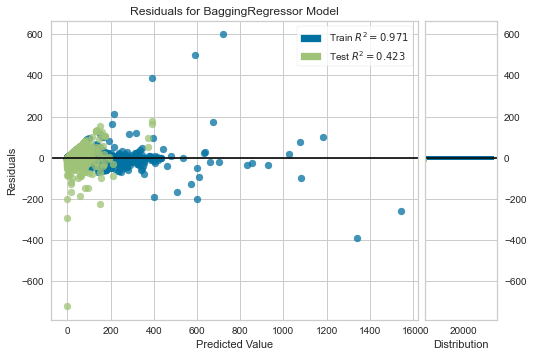

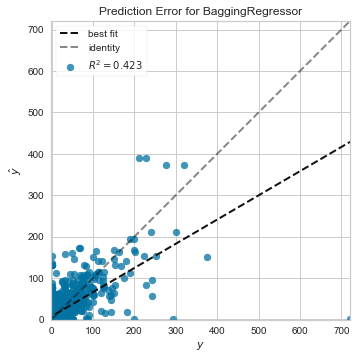

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Viz not yet implemented in Yellowbrinck for this model: BaggingRegressor


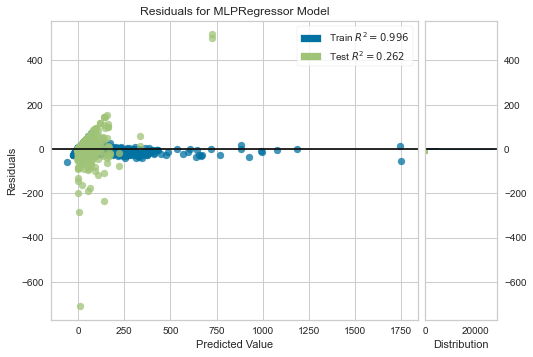

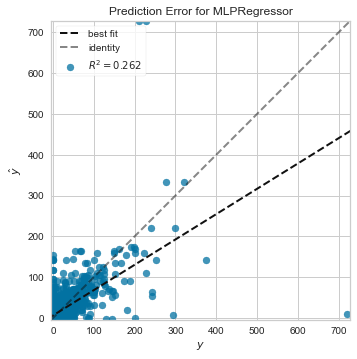

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Viz not yet implemented in Yellowbrinck for this model: MLPRegressor


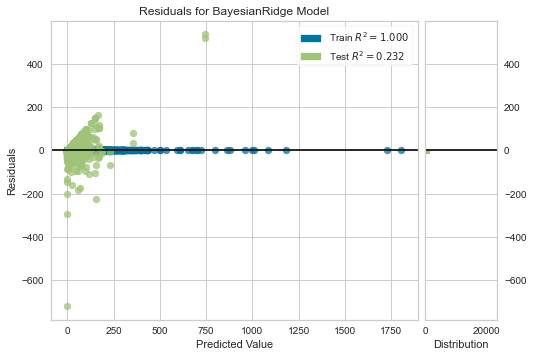

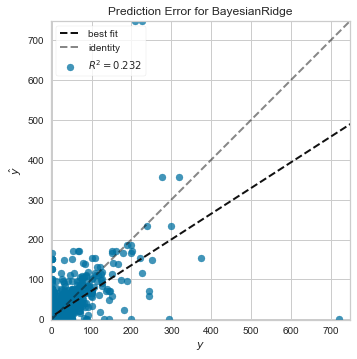

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


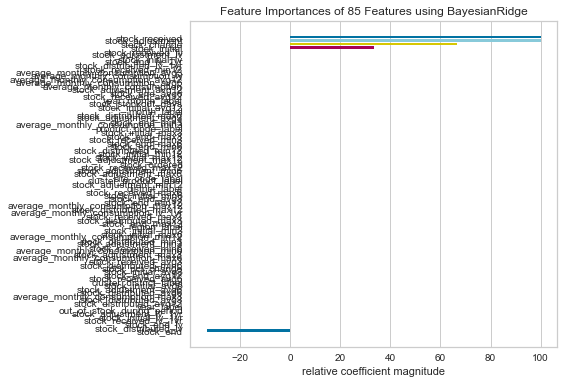

          model        r2       rmse      mase  r2-validated  rmse-validated  \
0  RandomForest  0.838669  14.747507  0.148047      0.425157       27.837721   

   mase-validated  
0         0.43304  


,model,r2,rmse,mase,r2-validated,rmse-validated,mase-validated
0,Pooled,1.000000,4.770837e-13,7.551058e-15,0.231817,32.180400,0.450352
0,XGBoost,0.940908,8.925314e+00,9.350835e-02,0.404131,28.342277,0.436055
0,Ridge,1.000000,8.409700e-06,1.535310e-07,0.231818,32.180398,0.450352
0,Lasso,0.999992,1.037102e-01,1.663255e-03,0.233422,32.146778,0.450201
0,RandomForest,0.838669,1.474751e+01,1.480472e-01,0.425157,27.837721,0.433040
0,BaggingRegressor,0.854371,1.401145e+01,1.543878e-01,0.423485,27.878199,0.435661
0,MLPRegressor,0.990505,3.577670e+00,5.947917e-02,0.262204,31.537509,0.447496
0,BayesianRidge,1.000000,7.198942e-04,1.319789e-05,0.231813,32.180484,0.450355


In [15]:
# Load Data
# Load primary data set
analytical_data = pd.read_csv("analytical_data/analytical_logistics_data.csv")

# Load supplementary data
# Product
product_data = pd.read_csv("analytical_data/product_data.csv")

# Site
site_data = pd.read_csv("analytical_data/augmented_site_info.csv")

# District
district_data = pd.read_csv("analytical_data/augmented_district_cluster.csv")

# Combine the datasets into one final dataset for modeling
# Note we lose one record in the merge from site and site_district
print(len(site_data))
site_district_data = site_data.merge(district_data,left_on='site_district',right_on='district',how="left")
print(len(site_district_data))


# Merge the data together
product_info = product_data.loc[:,['product_code','cluster_product']]
district_info = site_district_data.loc[:,['site_code','cluster_district']]
#
merged_analytical_dataset = analytical_data.merge(product_info,on='product_code')
analytical_dataset = merged_analytical_dataset.merge(district_info,left_on = 'site_code' ,right_on='site_code')
# Save this one for future analysis
final_analytical_data = analytical_dataset.copy()
# Set the data parameters

# Index cols
# Add the cluster labels to the index
index_cols = ['year','month','region',
              'district','site_code','product_code',
              'year_month','cluster_product','cluster_district']
# Target col
target_col = 'stock_distributed'

select_cols  = [ col for col in analytical_dataset.columns.values if col not in index_cols+[target_col]]


X_train, X_test, X_validate, y_train, y_test = create_datasets(
    analytical_dataset,
    target_col,
    select_cols,
    index_cols,
    ['year','month'])


# Select the models to test
test_models = {
    'Pooled':sm_OLS,
    'XGBoost' : XGBRegressor(n_estimators=100),
    'Ridge':Ridge(),
    'Lasso':Lasso(),
    'RandomForest':RandomForestRegressor(),
    'BaggingRegressor':BaggingRegressor(),
    'MLPRegressor':MLPRegressor(),
    'BayesianRidge':BayesianRidge(),
}




model_results = evaluate_dataset(X_train,
                                              X_test, # Validate the data
                                              X_validate,
                                              y_train,
                                              y_test,
                                              test_models,
                                              show_models=True)
model_results

## Final Model Selection

### Model Development

1. Select top model based on model results above.
2. Create model with analytically transformed historical data
3. Evaluate model with test(witheld records) and validate (inferred values) datasets

### Model Selection
- Model Selection is based on the best performing model by MASE from the validated datasets, the model and the accompanying dataset used to produce the minimum MASE are selected here for one final model evaluation.

In [17]:
# Load Data
model_data  = final_analytical_data.copy()

# Set the data parameters

# Add the cluster labels to the index
index_cols = ['year','month','region',
              'district','site_code','product_code',
              'year_month','cluster_product','cluster_district']
# Target col
target_col = 'stock_distributed'

# Select Features
select_cols  = [ col for col in model_data.columns.values if col not in index_cols+[target_col]]


# Create the model training sets
X_train, X_test, X_validate, y_train, y_test = create_datasets(model_data,target_col,select_cols,index_cols,timeseries_keys)


42


<ipython-input-4-138f77a55f63>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_valid = X_train[window_records]


### Evaluation of the final model
Creation of the data regression data visualizations provided by YB library.


In [18]:
# Create model
RFR_model = RandomForestRegressor() 

# Fit model
model_alpha = RFR_model.fit(X_train,y_train)

#### Plot Types

Redisuas Plot - Assess the magnitude of the residuals(errors) along the Predicted Value (y-hat).


Prediction Error Plot - Difference between predicted value and actual value in comparison to line of best fit.


Feature Importance - Weights of the the regressor coefficents.


#### Test Data

**Redisuas Plot**

- We can see there is a few large outliers in the training data but remember that the training data is much larger than the training dataset


**Prediction Error Plot**

- We can see there is residuals across the line suggesting that there is significant variation in values below 400 and there is a skw in predictions to be low. within the test data.

- We can see most of the data is strattified in values below 100, aditional analysis could yield new ways of labeling those values


**Feature Importance - Weights of the the regressor coefficents**

(0.8496174113363032, 0.14663375634354595, 14.238295519440834)


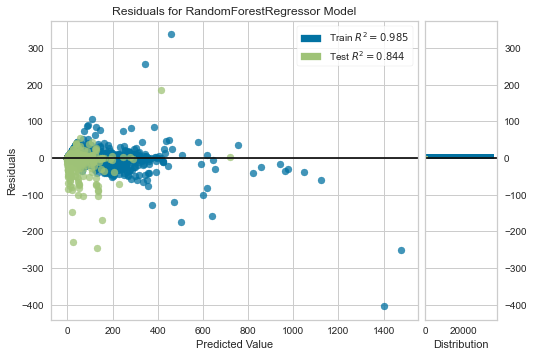

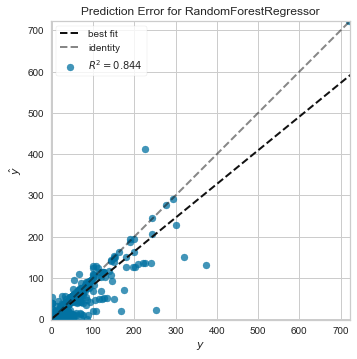

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


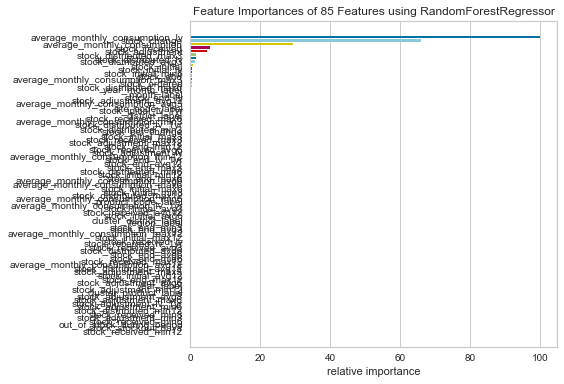

In [19]:
# Evaluate Model

eval_metrics, y_pred = predict_model(model_alpha,X_test,y_test)
#print(eval_metrics)

# The score based on our current model with no knowledge of the future results

val_metrics, vy_pred = predict_model(model_alpha,X_validate,y_test)
#print(val_metrics)

#Test
print(eval_metrics)
regressor_eval_vizs(RandomForestRegressor(),X_train,X_test,y_train,y_test)

#### Validate Data

**Redisuas Plot**

- We can the errors are more spread out between the model but most of them predominantly occuring in the predicted values less than 200.


**Prediction Error Plot**

- We can see there is a large robust number of errors below 100, there are several values along the Y-axis, indicating there were many instances when the model predicted a value when the value was 0 and there are a few instances along the x-axis, when the model predicted a value and the actual was 0.
- This seems to indicate that there is an existing feature to help explain the variance that we have not yet identified.

**Feature Importance - Weights of the the regressor coefficents**
- We can see that calculateions of the following variables have significant impact in the model:
    - monthly consumption
    - stock changes
    - stock received
    - stock adjustment
 - We can see that more recent aggregate calculations had an impact on the model (historical information)

(0.43724215739820205, 0.4307852781596077, 27.543555583601627)


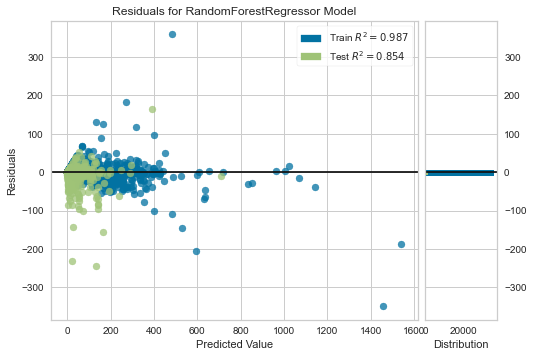

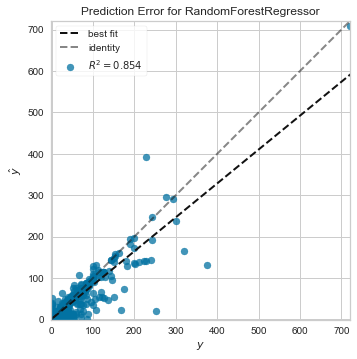

/usr/local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


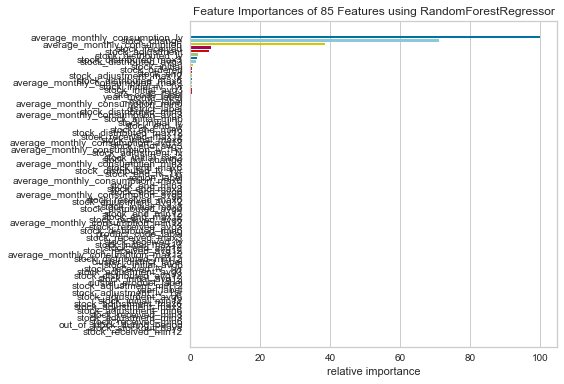

In [20]:
# Validation
print(val_metrics)
regressor_eval_vizs(RandomForestRegressor(),X_train,X_test,y_train,y_test)

# Next Steps


## Model Evaluation
- Overall we see that the Random Forest Regressor model has the best results on the analytically transformed data. However a majority of the models most important features are from the the original column features.

### Model Improvement

#### Input Data (X_test or X_validate)
- We could improve the ability to infer the true values of the input data in order to improve model performance. For example consider changing the window size for the number of historical records to aggregate by.

#### Additional Training Data
- Is there more data that we can add to improve model. 



## Model Selection
The following models have been developed in this repository but are not currently implemented in this notebook. Both models have shown strong potential in providing improved model performance with timeseries data.

### Non-Pooled OLS

### Neural Networks